In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1005. Miscellaneous Analyses/P1005.7. EV Proteomics/P1005.7.3. Analyses/P1005.7.3.1. Data Processing')
cur_date = "013124"

library(readxl)
library(openxlsx)
library(tidyverse)
library(imputeLCMD)
library(factoextra)
library(vegan)
library(preprocessCore)

# reading in files
proteome_df = data.frame(read_excel("Input/EV_function_proteomics_012924.xlsx")) %>%
    rename(Protein = Accession, Unique_Peptides = Number_of_UniquePeptides)

# for some reason this col was read in as a character not numeric
proteome_df$PFAS.CEV_R2 = as.numeric(proteome_df$PFAS.CEV_R2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: tmvtnorm

Loading required package: mvtnorm

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: stats4

Loading required package: gmm

Loading required package: sandwich

Loading required package: norm

This package has some major limitations
(for example, it does not work reliably when
the number of variables exceeds 30),
an

In [2]:
head(proteome_df)

,Protein,Unique_Peptides,Control_R1,Control_R2,Control_R3,Control_R4,Control_R5,Control_R6,CEV_R1,CEV_R2,⋯,PFAS.CEV_R3,PFAS.CEV_R4,PFAS.CEV_R5,PFAS.CEV_R6,PFAS.PEV_R1,PFAS.PEV_R2,PFAS.PEV_R3,PFAS.PEV_R4,PFAS.PEV_R5,PFAS.PEV_R6
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,P00761,13,46631776,51326464,63449032,46508708,32194210,23975652,50760076,39610572,⋯,78471912,61208496,65192580,63247004,49543192,62553512,69856432,92588176,69703720,87109000
2,P60709,44,14898485,14393858,18238848,18135594,16799740,17023620,14949095,15522869,⋯,23687454,21942680,25449002,20706812,22377822,20689196,20683342,23522216,22659790,22152380
3,P0C0S8;Q96KK5;Q99878;Q9BTM1,11,1977650,2275874,7578563,14216659,8436507,10723020,1744173,3018039,⋯,42397020,41915100,63571952,34687048,14175319,12150578,26680958,43462264,49627204,48483936
4,P23527,19,1365104,1798281,5384082,10863599,6436632,7903236,1547090,2131009,⋯,25425400,28165144,37935572,27360386,8919584,10832857,19775876,29996800,34656756,40720276
5,P68104,51,12752274,13042510,11823310,11414176,11093480,10846471,12069089,12141256,⋯,12803181,10858694,11959423,10805138,13487166,12406781,12351198,10652401,10221360,11634231
6,P06733,54,8854008,8850713,10123283,8877717,8250112,8561273,8166417,9454755,⋯,12480849,11187431,12152479,9926687,12584716,9863353,10702597,13051212,11816466,10026787


In [3]:
longer_proteome_df = proteome_df %>%
    pivot_longer(cols = 3:38, names_to = "ID", values_to = "Value") %>%
   # mutate(Treatment = ID) %>%
    separate(ID, c('Treatment', NA), sep = "_", remove = FALSE)

head(longer_proteome_df)

Protein,Unique_Peptides,ID,Treatment,Value
<chr>,<dbl>,<chr>,<chr>,<dbl>
P00761,13,Control_R1,Control,46631776
P00761,13,Control_R2,Control,51326464
P00761,13,Control_R3,Control,63449032
P00761,13,Control_R4,Control,46508708
P00761,13,Control_R5,Control,32194210
P00761,13,Control_R6,Control,23975652


In [4]:
# intial number of proteins prior to filtering
length(unique(proteome_df$Protein))

[1] 7103

# 1. Peptide Normalization
Normalize to total amount of peptide per sample: sum the abundance values for each sample, then calculate the median value across all of the summed abundance values, and calculate the ratio

In [5]:
normalized_df = longer_proteome_df %>%
    group_by(ID) %>%
    #removing missing data
    drop_na() %>%
    mutate(Summed_Value = sum(Value)) %>%
    #calculating median across all samples but still within each set
    ungroup() %>%
    mutate(Median_of_Sum = median(Summed_Value), Norm_Factor = Summed_Value/ Median_of_Sum, 
           Norm_Value = Value/Norm_Factor) %>%
    select(-c("Summed_Value", "Median_of_Sum", "Norm_Factor"))

head(normalized_df)

Protein,Unique_Peptides,ID,Treatment,Value,Norm_Value
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
P00761,13,Control_R1,Control,46631776,48817716
P00761,13,Control_R2,Control,51326464,54279744
P00761,13,Control_R3,Control,63449032,63449032
P00761,13,Control_R4,Control,46508708,46728346
P00761,13,Control_R5,Control,32194210,34552783
P00761,13,Control_R6,Control,23975652,25655376


# 2. Detection Filter - Round 1
Round 1 - Unable to replicate the 1% peptide/ 5% protein FDR, so we'll just retain proteins that were identified by at least 2 peptides.

In [6]:
# only keeping proteins > 2 unique proteins
detection_filter_1_df = longer_proteome_df %>%
    filter(Unique_Peptides > 2)

head(detection_filter_1_df)

length(unique(detection_filter_1_df$Protein))

Protein,Unique_Peptides,ID,Treatment,Value
<chr>,<dbl>,<chr>,<chr>,<dbl>
P00761,13,Control_R1,Control,46631776
P00761,13,Control_R2,Control,51326464
P00761,13,Control_R3,Control,63449032
P00761,13,Control_R4,Control,46508708
P00761,13,Control_R5,Control,32194210
P00761,13,Control_R6,Control,23975652


[1] 6727

# 3. Detection Filter - Round 2
Round 2 - Filter rows based on valid values: 50 % valid in each treatment group (i.e. proteins with values observed in fewer than 50% of replicates (here, 3 reps) in at least 1 condition were eliminated from the dataset)

In [7]:
protein_presence_df = detection_filter_1_df %>%
    # creating 2 count cols: 1st for non-missing data, 2nd for all data
    mutate(data_count = ifelse(is.na(Value), 0, 1), all_count = 1) %>%
    group_by(Protein, Treatment) %>%
    summarize(Protein_Presence = sum(data_count)/ sum(all_count) * 100) %>%
    filter(Protein_Presence < 50) %>%
    arrange(Protein_Presence) 

head(protein_presence_df)

# getting the proteins in the entire set that will be removed
removed_proteins_df = protein_presence_df %>%
    ungroup() %>%
    select(-Protein_Presence) %>% 
    unique()

# number of proteins removed from each set for the 2nd detection filter
removed_proteins_df %>%
    summarize(`Removed Proteins` = length(unique(Protein)))

`summarise()` has grouped output by 'Protein'. You can override using the
`.groups` argument.


Protein,Treatment,Protein_Presence
<chr>,<chr>,<dbl>
A3EZ82;Q6E0U4,PFAS,0
A3EZ82;Q6E0U4,PFAS.CEV,0
A3EZ82;Q6E0U4,PFAS.PEV,0
O00762,PFAS,0
O00762,PFAS.PEV,0
O14682,PFAS,0


Removed Proteins
<int>
129


In [8]:
# removing those 129 proteins from the entire dataset 
# finding proteins that exist only in the proteome_df but not the removed proteins_df
detection_filter_2_df = anti_join(detection_filter_1_df, removed_proteins_df)
head(detection_filter_2_df)

# number of proteins kept
detection_filter_2_df %>%
    group_by(Treatment) %>%
    summarize(`Kept Proteins` = length(unique(Protein)))

Joining with `by = join_by(Protein, Treatment)`


Protein,Unique_Peptides,ID,Treatment,Value
<chr>,<dbl>,<chr>,<chr>,<dbl>
P00761,13,Control_R1,Control,46631776
P00761,13,Control_R2,Control,51326464
P00761,13,Control_R3,Control,63449032
P00761,13,Control_R4,Control,46508708
P00761,13,Control_R5,Control,32194210
P00761,13,Control_R6,Control,23975652


Treatment,Kept Proteins
<chr>,<int>
CEV,6699
Control,6694
PEV,6701
PFAS,6659
PFAS.CEV,6633
PFAS.PEV,6643


# 4. QRILC Imputation
QRILC replaces data with left-censored data from a Gaussian distribution.

In [9]:
# adding in normalized values to the filtered df
# left join returns all the records from the first table along with matching records from the second
preimputed_df = left_join(detection_filter_2_df, normalized_df) %>% 
                       select(-Unique_Peptides)

head(preimputed_df)

Joining with `by = join_by(Protein, Unique_Peptides, ID, Treatment, Value)`


Protein,ID,Treatment,Value,Norm_Value
<chr>,<chr>,<chr>,<dbl>,<dbl>
P00761,Control_R1,Control,46631776,48817716
P00761,Control_R2,Control,51326464,54279744
P00761,Control_R3,Control,63449032,63449032
P00761,Control_R4,Control,46508708,46728346
P00761,Control_R5,Control,32194210,34552783
P00761,Control_R6,Control,23975652,25655376


In [10]:
# QRILC
QRILC_imputation = function(dataset){
    # """
    # Creating a quantile normalization function to normalize each sample.
    # :param (input): exposed and unexposed (vehicle) dfs
    # :output: 1 quantile normalized df
    # """
    wider_dataset = dataset %>%
        select(-c("Value", "Treatment")) %>%
        pivot_wider(names_from = Protein, values_from = Norm_Value) 
    
    # normalizing data since that's what the QRILC function wants
    QRILC_prep = wider_dataset[,2:dim(wider_dataset)[2]] %>%
         mutate_all(., function(x) log2(x)) %>%
         as.matrix()

    imputed_QRILC_object = impute.QRILC(QRILC_prep, tune.sigma = 0.1)
    QRILC_log2_df = data.frame(imputed_QRILC_object[1]) 
    
    # converting back the original scale
    QRILC_df = QRILC_log2_df %>%
        mutate_all(., function(x) 2^x - 1)
    
    # adding back in ID col
    QRILC_df = cbind(ID = wider_dataset$ID, QRILC_df)
            
    # adding back in Tx and Set columns
    final_pivoted_column_number = dim(QRILC_df)[2] + 1

    imputed_dataset = inner_join(unique(dataset %>% 
                                  select(ID, Treatment)), QRILC_df) %>%
        pivot_longer(cols = 3:all_of(final_pivoted_column_number), names_to = "Protein", values_to = "Value")

   return(imputed_dataset)
}

# calling fn
imputed_df = QRILC_imputation(preimputed_df)   
                   
head(imputed_df)

Joining with `by = join_by(ID)`


ID,Treatment,Protein,Value
<chr>,<chr>,<chr>,<dbl>
Control_R1,Control,P00761,48817715
Control_R1,Control,P60709,15596874
Control_R1,Control,P0C0S8.Q96KK5.Q99878.Q9BTM1,2070354
Control_R1,Control,P23527,1429094
Control_R1,Control,P68104,13350056
Control_R1,Control,P06733,9269053


# 5. PCA
Using PCA to identify and remove outlier samples.

In [11]:
# prepping dfs for PCA
pca_prep_df = imputed_df %>%
    select(-Treatment) %>%
    pivot_wider(names_from = Protein, values_from = Value) %>%
    column_to_rownames(var = "ID")

head(pca_prep_df)

,P00761,P60709,P0C0S8.Q96KK5.Q99878.Q9BTM1,P23527,P68104,P06733,P68363,P04406,P10809,P08238,⋯,A8K2U0,Q9HAW4,O14682,Q9NSG2,Q66K64,Q6IQ21,Q5T3U5,Q6PIY7,P30838,P48552
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Control_R1,48817715,15596874,2070354,1429094,13350056,9269053,10759692,9587007,6998959,8720277,⋯,2461.9600,2259.1018,1606.198,889.3676,1487.988,617.2214,1294.4742,988.4019,38.52594,343.9317
Control_R2,54279743,15222067,2406825,1901751,13792964,9359974,10725033,8590549,6884546,8845121,⋯,460.4152,1712.1699,1981.276,1297.1294,1681.207,1617.0105,1009.5331,1034.7255,41.19862,594.9375
Control_R3,63449031,18238847,7578562,5384081,11823309,10123282,9479165,9126735,5676130,8681320,⋯,1078.8457,922.9499,1061.671,765.6619,1300.664,1421.1478,2803.9014,1035.4186,29.80152,200.9883
Control_R4,46728345,18221239,14283796,10914901,11468079,8919641,8409056,8193105,6050519,7445616,⋯,552.3073,558.6850,1039.775,1449.3656,1315.565,718.3444,222.9229,657.9548,48.54330,607.2432
Control_R5,34552782,18030501,9054571,6908184,11906196,8854520,10075132,8093675,6160617,7608202,⋯,568.8454,1987.8420,2043.968,1161.7798,1794.740,811.7983,1212.7284,1288.3598,38.88644,482.2952
Control_R6,25655375,18216287,11474269,8456932,11606369,9161071,9246505,7982725,6539705,7898723,⋯,8019.0286,2138.4565,1326.427,2434.8754,1323.687,1016.1433,615.3126,1071.8126,21.63534,888.8715


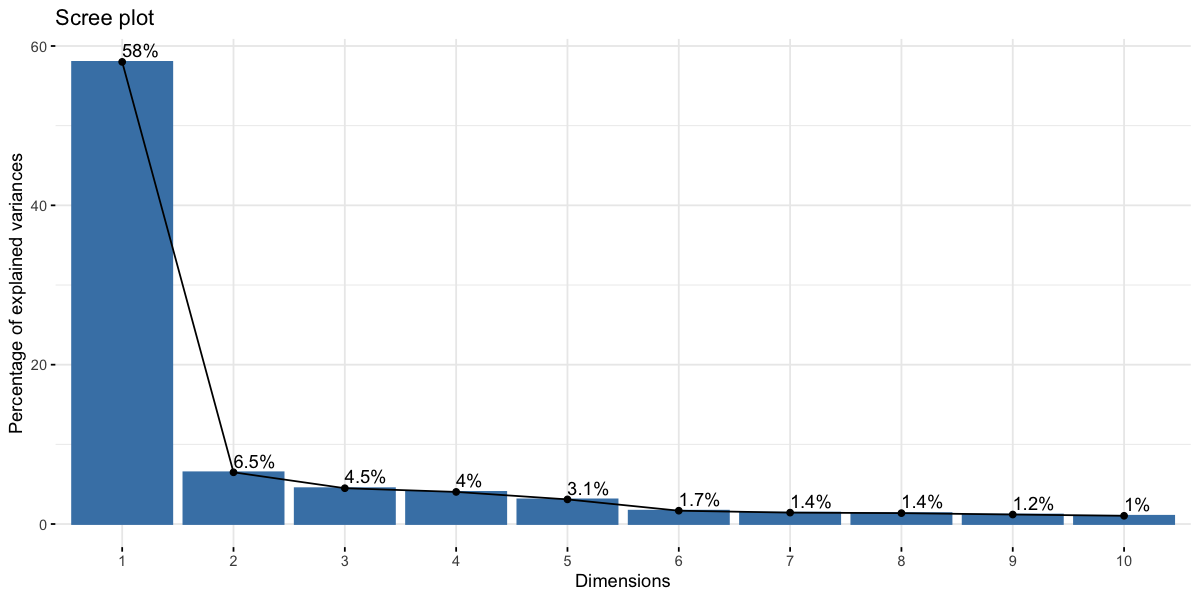

In [12]:
# running PCA
pca = prcomp(pca_prep_df, scale = TRUE)

# viewing scree plots to see how much of the variance was captured in first 2 eigenvectors
options(repr.plot.width=10, repr.plot.height=5) #changing size
fviz_eig(pca, addlabels = TRUE)

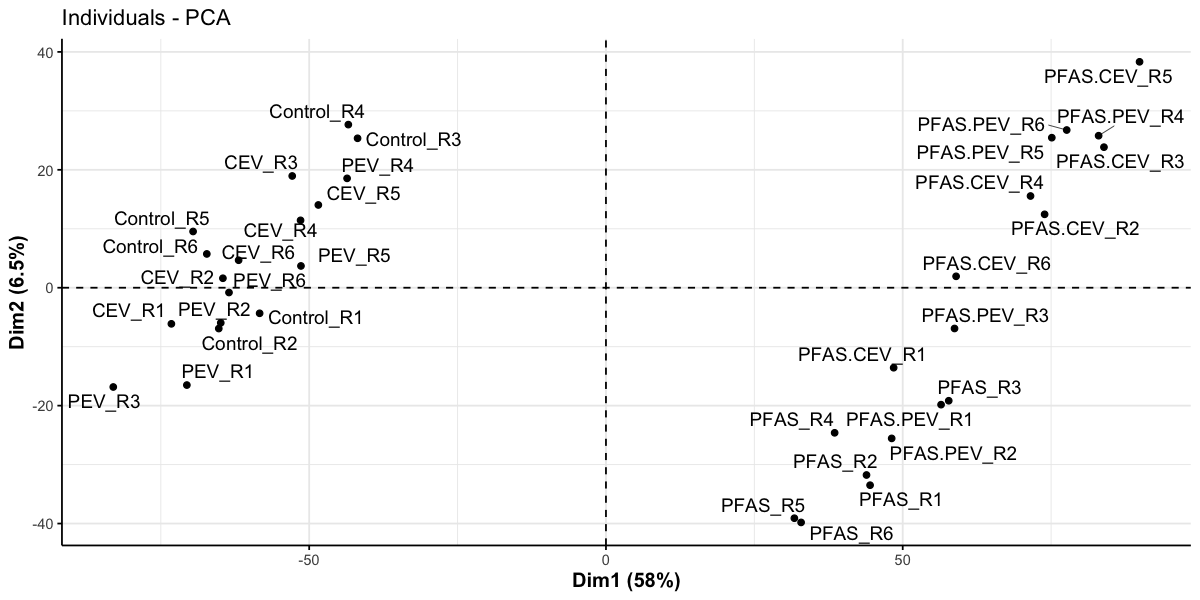

In [13]:
# visualizing all data to detect outliers
fviz_pca_ind(pca, 
             repel = TRUE) +
theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.text = element_text(size = 8),
      axis.title = element_text(face = "bold", size = rel(1.1))) #changes axis titles

I'll use a formula to detect outliers rather than visual inspection, since there aren't any obvious outliers.

The standard way to detect outliers in genetics is the criterion of being “more than 6 standard deviations away from the mean”. [source](https://privefl.github.io/blog/detecting-outlier-samples-in-pca/)

In [14]:
outlier_detection = function(pca_df){
    # """
    # Creating a scoring function for to detect PCA sample outliers. 
    # :param (input): PCA df (df)
    # :output: outlier names
    # """
    
    # getting scores
    scores = pca_df$x
    # identifying samples that are > 6 standard deviations away from the mean
    outlier_indices = apply(scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)
    # getting sample names
    outliers = rownames(scores)[outlier_indices]
    
    return(outliers)
}

# calling fn
outliers = outlier_detection(pca)            

In [15]:
# number of samples to be removed from this filter
length(outliers)

[1] 0

In [16]:
# removing those outliers (even though there were none)
`%notin%` <- Negate(`%in%`)

removed_outliers_df = imputed_df %>%
    filter(ID %notin% outliers)

In [17]:
# creating 1 final df with protiens that passed all filters
final_df = removed_outliers_df

head(final_df)

ID,Treatment,Protein,Value
<chr>,<chr>,<chr>,<dbl>
Control_R1,Control,P00761,48817715
Control_R1,Control,P60709,15596874
Control_R1,Control,P0C0S8.Q96KK5.Q99878.Q9BTM1,2070354
Control_R1,Control,P23527,1429094
Control_R1,Control,P68104,13350056
Control_R1,Control,P06733,9269053


In [18]:
# final number of proteins for each treatment
final_df %>%
    group_by(Treatment) %>%
    summarize(`Final Number of Proteins` = length(unique(Protein)))

Treatment,Final Number of Proteins
<chr>,<int>
CEV,6715
Control,6715
PEV,6715
PFAS,6715
PFAS.CEV,6715
PFAS.PEV,6715


In [19]:
# exporting
write.xlsx(final_df, paste0(Output,"/", "Imputed_Proteomics_Data_", cur_date, ".xlsx"), 
           rowNames = FALSE)